In [388]:
import pathlib
import h5py

import numpy as np
import matplotlib.pyplot as plt

## Existing singlecoil_test knee data: original or the split we used for NeurIPS?

In [389]:
data_folder = pathlib.Path('/home/timsey/HDD/data/fastMRI/singlecoil')

<HDF5 file "file1000003.h5" (mode r)>


/home/timsey/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:11: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  # This is added back by InteractiveShellApp.init_path()


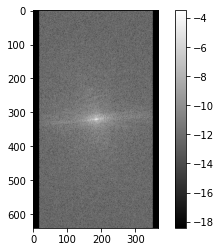

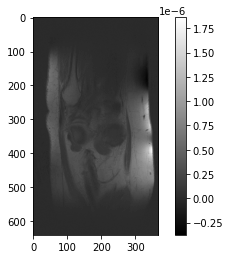

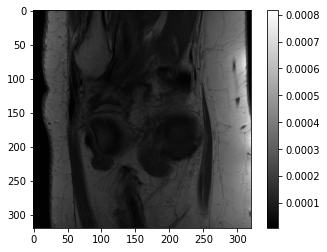

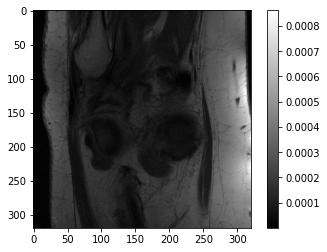

In [390]:
partition = "test"

partition_folder = data_folder / f"singlecoil_{partition}"
for fname in partition_folder.iterdir():
    if not fname.name.endswith('.h5'):
        continue  # Skip directories
        
    f = h5py.File(fname, 'r')
    print(f)
    
    complex_k = f["kspace"].value
    complex_img = np.fft.ifftshift(
        np.fft.ifft2(
            np.fft.fftshift(complex_k, axes=(-2, -1)), axes=(-2, -1)
        ), axes=(-2, -1)
    )
    
    img_index = 30
    
    # k-space
    plt.imshow(np.log(np.abs(complex_k.real[img_index]) + 1e-8), cmap="gray")
    plt.colorbar()
    plt.show()
    
    # From k-space
    plt.imshow(complex_img.real[img_index], cmap="gray")
    plt.colorbar()
    plt.show()
    
    # From RSS
    plt.imshow(f["reconstruction_rss"][img_index], cmap="gray")
    plt.colorbar()
    plt.show()
    
    # From ESC
    plt.imshow(f["reconstruction_esc"][img_index], cmap="gray")
    plt.colorbar()
    plt.show()
    
    break

### Conclusion
`singlecoil_test` folder is the test data we used for NeurIPS MRI paper: not the original test data.

## Find metadata

In [391]:
dict(f.attrs.items())

{'acquisition': 'CORPD_FBK',
 'max': 0.0011196501434476845,
 'norm': 0.34417799215708206,
 'patient_id': '677ac6bd798aca92edebad9da68aa744609053cc748717fb327d5ac18ed6b328'}

In [392]:
f.keys()

<KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']>

In [393]:
import xml.etree.ElementTree as etree

def et_query(
    root: etree.Element,
    qlist,
    namespace: str = "http://www.ismrm.org/ISMRMRD",
) -> str:
    """
    ElementTree query function.
    This can be used to query an xml document via ElementTree. It uses qlist
    for nested queries.
    Args:
        root: Root of the xml to search through.
        qlist: A list of strings for nested searches, e.g. ["Encoding",
            "matrixSize"]
        namespace: Optional; xml namespace to prepend query.
    Returns:
        The retrieved data as a string.
    """
    s = "."
    prefix = "ismrmrd_namespace"

    ns = {prefix: namespace}

    for el in qlist:
        s = s + f"//{prefix}:{el}"

    value = root.find(s, ns)
    if value is None:
        raise RuntimeError("Element not found")

    return str(value.text)

et_root = etree.fromstring(f["ismrmrd_header"][()])

In [85]:
patient_position = et_query(et_root, ["measurementInformation", "patientPosition"])
protocol = et_query(et_root, ["measurementInformation", "protocolName"])

vendor = et_query(et_root, ["acquisitionSystemInformation", "systemVendor"])
model = et_query(et_root, ["acquisitionSystemInformation", "systemModel"])
field_strength = et_query(et_root, ["acquisitionSystemInformation", "systemFieldStrength_T"])
noise_bandwidth = et_query(et_root, ["acquisitionSystemInformation", "relativeReceiverNoiseBandwidth"])
channels = et_query(et_root, ["acquisitionSystemInformation", "receiverChannels"])
institution = et_query(et_root, ["acquisitionSystemInformation", "institutionName"])

print(patient_position, protocol)
print(vendor, model, field_strength, noise_bandwidth, channels, institution)

FFS COR
SIEMENS Skyra 2.893620 0.793000 15 NYU


In [394]:
# https://jsonformatter.org/xml-viewer

# Use: f["ismrmrd_header"][()] to get input.

# Input of form:
    
# <ismrmrdHeader xmlns="http://www.ismrm.org/ISMRMRD" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:xs="http://www.w3.org/2001/XMLSchema" xsi:schemaLocation="http://www.ismrm.org/ISMRMRD ismrmrd.xsd">
# BLABLABLA ------- \n\t<studyInformation>\n\t\t<studyTime>10:19:59</studyTime>\n\t</studyInformation>\n\t<measurementInformation>\n\t\t<measurementID>45167_46904023_46904032_927</measurementID>\n\t\t<patientPosition>FFS</patientPosition>\n\t\t<protocolName>COR</protocolName>\n\t\t<frameOfReferenceUID>1.3.12.2.1107.5.2.19.45167.1.20180214100837761.0.0.5002</frameOfReferenceUID>\n\t</measurementInformation>\n\t<acquisitionSystemInformation>\n\t\t<systemVendor>SIEMENS</systemVendor>\n\t\t<systemModel>Skyra</systemModel>\n\t\t<systemFieldStrength_T>2.893620</systemFieldStrength_T>\n\t\t<relativeReceiverNoiseBandwidth>0.793000</relativeReceiverNoiseBandwidth>\n\t\t<receiverChannels>15</receiverChannels>\n\t\t<coilLabel>\n\t\t\t<coilNumber>42</coilNumber>\n\t\t\t<coilName>TxRx_15Ch_Knee:1:K5</coilName>\n\t\t</coilLabel>\n\t\t<coilLabel>\n\t\t\t<coilNumber>41</coilNumber>\n\t\t\t<coilName>TxRx_15Ch_Knee:1:K15</coilName>\n\t\t</coilLabel>\n\t\t<coilLabel>\n\t\t\t<coilNumber>26</coilNumber>\n\t\t\t<coilName>TxRx_15Ch_Knee:1:K9</coilName>\n\t\t</coilLabel>\n\t\t<coilLabel>\n\t\t\t<coilNumber>25</coilNumber>\n\t\t\t<coilName>TxRx_15Ch_Knee:1:K4</coilName>\n\t\t</coilLabel>\n\t\t<coilLabel>\n\t\t\t<coilNumber>30</coilNumber>\n\t\t\t<coilName>TxRx_15Ch_Knee:1:K7</coilName>\n\t\t</coilLabel>\n\t\t<coilLabel>\n\t\t\t<coilNumber>29</coilNumber>\n\t\t\t<coilName>TxRx_15Ch_Knee:1:K8</coilName>\n\t\t</coilLabel>\n\t\t<coilLabel>\n\t\t\t<coilNumber>46</coilNumber>\n\t\t\t<coilName>TxRx_15Ch_Knee:1:K1</coilName>\n\t\t</coilLabel>\n\t\t<coilLabel>\n\t\t\t<coilNumber>18</coilNumber>\n\t\t\t<coilName>TxRx_15Ch_Knee:1:K6</coilName>\n\t\t</coilLabel>\n\t\t<coilLabel>\n\t\t\t<coilNumber>17</coilNumber>\n\t\t\t<coilName>TxRx_15Ch_Knee:1:K14</coilName>\n\t\t</coilLabel>\n\t\t<coilLabel>\n\t\t\t<coilNumber>22</coilNumber>\n\t\t\t<coilName>TxRx_15Ch_Knee:1:K10</coilName>\n\t\t</coilLabel>\n\t\t<coilLabel>\n\t\t\t<coilNumber>21</coilNumber>\n\t\t\t<coilName>TxRx_15Ch_Knee:1:K13</coilName>\n\t\t</coilLabel>\n\t\t<coilLabel>\n\t\t\t<coilNumber>34</coilNumber>\n\t\t\t<coilName>TxRx_15Ch_Knee:1:K3</coilName>\n\t\t</coilLabel>\n\t\t<coilLabel>\n\t\t\t<coilNumber>33</coilNumber>\n\t\t\t<coilName>TxRx_15Ch_Knee:1:K2</coilName>\n\t\t</coilLabel>\n\t\t<coilLabel>\n\t\t\t<coilNumber>38</coilNumber>\n\t\t\t<coilName>TxRx_15Ch_Knee:1:K12</coilName>\n\t\t</coilLabel>\n\t\t<coilLabel>\n\t\t\t<coilNumber>37</coilNumber>\n\t\t\t<coilName>TxRx_15Ch_Knee:1:K11</coilName>\n\t\t</coilLabel>\n\t\t<institutionName>NYU</institutionName>\n\t</acquisitionSystemInformation>\n\t<experimentalConditions>\n\t\t<H1resonanceFrequency_Hz>123239202</H1resonanceFrequency_Hz>\n\t</experimentalConditions>\n\t<encoding>\n\t\t<encodedSpace>\n\t\t\t<matrixSize>\n\t\t\t\t<x>640</x>\n\t\t\t\t<y>368</y>\n\t\t\t\t<z>1</z>\n\t\t\t</matrixSize>\n\t\t\t<fieldOfView_mm>\n\t\t\t\t<x>280.000000</x>\n\t\t\t\t<y>161.419998</y>\n\t\t\t\t<z>4.500000</z>\n\t\t\t</fieldOfView_mm>\n\t\t</encodedSpace>\n\t\t<reconSpace>\n\t\t\t<matrixSize>\n\t\t\t\t<x>320</x>\n\t\t\t\t<y>320</y>\n\t\t\t\t<z>1</z>\n\t\t\t</matrixSize>\n\t\t\t<fieldOfView_mm>\n\t\t\t\t<x>140.000000</x>\n\t\t\t\t<y>140.000000</y>\n\t\t\t\t<z>3.000000</z>\n\t\t\t</fieldOfView_mm>\n\t\t</reconSpace>\n\t\t<encodingLimits>\n\t\t\t<kspace_encoding_step_1>\n\t\t\t\t<minimum>0</minimum>\n\t\t\t\t<maximum>331</maximum>\n\t\t\t\t<center>166</center>\n\t\t\t</kspace_encoding_step_1>\n\t\t\t<kspace_encoding_step_2>\n\t\t\t\t<minimum>0</minimum>\n\t\t\t\t<maximum>0</maximum>\n\t\t\t\t<center>0</center>\n\t\t\t</kspace_encoding_step_2>\n\t\t\t<average>\n\t\t\t\t<minimum>0</minimum>\n\t\t\t\t<maximum>0</maximum>\n\t\t\t\t<center>0</center>\n\t\t\t</average>\n\t\t\t<slice>\n\t\t\t\t<minimum>0</minimum>\n\t\t\t\t<maximum>44</maximum>\n\t\t\t\t<center>0</center>\n\t\t\t</slice>\n\t\t\t<contrast>\n\t\t\t\t<minimum>0</minimum>\n\t\t\t\t<maximum>0</maximum>\n\t\t\t\t<center>0</center>\n\t\t\t</contrast>\n\t\t\t<phase>\n\t\t\t\t<minimum>0</minimum>\n\t\t\t\t<maximum>0</maximum>\n\t\t\t\t<center>0</center>\n\t\t\t</phase>\n\t\t\t<repetition>\n\t\t\t\t<minimum>0</minimum>\n\t\t\t\t<maximum>0</maximum>\n\t\t\t\t<center>0</center>\n\t\t\t</repetition>\n\t\t\t<set>\n\t\t\t\t<minimum>0</minimum>\n\t\t\t\t<maximum>0</maximum>\n\t\t\t\t<center>0</center>\n\t\t\t</set>\n\t\t\t<segment>\n\t\t\t\t<minimum>0</minimum>\n\t\t\t\t<maximum>0</maximum>\n\t\t\t\t<center>0</center>\n\t\t\t</segment>\n\t\t</encodingLimits>\n\t\t<trajectory>cartesian</trajectory>\n\t\t<parallelImaging>\n\t\t\t<accelerationFactor>\n\t\t\t\t<kspace_encoding_step_1>1</kspace_encoding_step_1>\n\t\t\t\t<kspace_encoding_step_2>1</kspace_encoding_step_2>\n\t\t\t</accelerationFactor>\n\t\t\t<calibrationMode>other</calibrationMode>\n\t\t</parallelImaging>\n\t</encoding>\n\t<sequenceParameters>\n\t\t<TR>2750.000000</TR>\n\t\t<TE>27.000000</TE>\n\t\t<TI>100.000000</TI>\n\t\t<flipAngle_deg>140.000000</flipAngle_deg>\n\t\t<sequence_type>TurboSpinEcho</sequence_type>\n\t\t<echo_spacing>8.850000</echo_spacing>\n\t</sequenceParameters>\n\t<userParameters>\n\t\t<userParameterDouble>\n\t\t\t<name>MaxwellCoefficient_0</name>\n\t\t\t<value>0.000000</value>\n\t\t</userParameterDouble>\n\t\t<userParameterDouble>\n\t\t\t<name>MaxwellCoefficient_1</name>\n\t\t\t<value>0.000000</value>\n\t\t</userParameterDouble>\n\t\t<userParameterDouble>\n\t\t\t<name>MaxwellCoefficient_2</name>\n\t\t\t<value>0.000000</value>\n\t\t</userParameterDouble>\n\t\t<userParameterDouble>\n\t\t\t<name>MaxwellCoefficient_3</name>\n\t\t\t<value>0.000000</value>\n\t\t</userParameterDouble>\n\t\t<userParameterDouble>\n\t\t\t<name>MaxwellCoefficient_4</name>\n\t\t\t<value>0.000000</value>\n\t\t</userParameterDouble>\n\t\t<userParameterDouble>\n\t\t\t<name>MaxwellCoefficient_5</name>\n\t\t\t<value>0.000000</value>\n\t\t</userParameterDouble>\n\t\t<userParameterDouble>\n\t\t\t<name>MaxwellCoefficient_6</name>\n\t\t\t<value>0.000000</value>\n\t\t</userParameterDouble>\n\t\t<userParameterDouble>\n\t\t\t<name>MaxwellCoefficient_7</name>\n\t\t\t<value>0.000000</value>\n\t\t</userParameterDouble>\n\t\t<userParameterDouble>\n\t\t\t<name>MaxwellCoefficient_8</name>\n\t\t\t<value>0.000000</value>\n\t\t</userParameterDouble>\n\t\t<userParameterDouble>\n\t\t\t<name>MaxwellCoefficient_9</name>\n\t\t\t<value>0.000000</value>\n\t\t</userParameterDouble>\n\t\t<userParameterDouble>\n\t\t\t<name>MaxwellCoefficient_10</name>\n\t\t\t<value>0.000000</value>\n\t\t</userParameterDouble>\n\t\t<userParameterDouble>\n\t\t\t<name>MaxwellCoefficient_11</name>\n\t\t\t<value>0.000000</value>\n\t\t</userParameterDouble>\n\t\t<userParameterDouble>\n\t\t\t<name>MaxwellCoefficient_12</name>\n\t\t\t<value>0.000000</value>\n\t\t</userParameterDouble>\n\t\t<userParameterDouble>\n\t\t\t<name>MaxwellCoefficient_13</name>\n\t\t\t<value>0.000000</value>\n\t\t</userParameterDouble>\n\t\t<userParameterDouble>\n\t\t\t<name>MaxwellCoefficient_14</name>\n\t\t\t<value>0.000000</value>\n\t\t</userParameterDouble>\n\t\t<userParameterDouble>\n\t\t\t<name>MaxwellCoefficient_15</name>\n\t\t\t<value>0.000000</value>\n\t\t</userParameterDouble>\n\t</userParameters>\n
# </ismrmrdHeader>

In [395]:
def get_partition_metadata(data_folder, partition):
    vendor_models = {}

    partition_folder = data_folder / f"singlecoil_{partition}"
    for i, fname in enumerate(partition_folder.iterdir()):
#         if i % 30 == 0:
#             print(f"File {i+1}")

        if not fname.name.endswith('.h5'):
            continue  # Skip directories

        f = h5py.File(fname, 'r')

        et_root = etree.fromstring(f["ismrmrd_header"][()])

        patient_position = et_query(et_root, ["measurementInformation", "patientPosition"])
        protocol = et_query(et_root, ["measurementInformation", "protocolName"])

        vendor = et_query(et_root, ["acquisitionSystemInformation", "systemVendor"])
        model = et_query(et_root, ["acquisitionSystemInformation", "systemModel"])
        field_strength = et_query(et_root, ["acquisitionSystemInformation", "systemFieldStrength_T"])
        noise_bandwidth = et_query(et_root, ["acquisitionSystemInformation", "relativeReceiverNoiseBandwidth"])
        channels = et_query(et_root, ["acquisitionSystemInformation", "receiverChannels"])
        institution = et_query(et_root, ["acquisitionSystemInformation", "institutionName"])

    #     print(patient_position, protocol)
    #     print(vendor, model, field_strength, noise_bandwidth, channels, institution)

        key = f"{vendor}_{model}"
        if key not in vendor_models:
            vendor_models[key] = 1
        else:
            vendor_models[key] += 1

    return vendor_models


partitions = ["train", "val", "test"]
for partition in partitions:
    vendor_models = get_partition_metadata(data_folder, partition)
    print(partition, vendor_models)

train {'SIEMENS_Skyra': 335, 'SIEMENS_Aera': 325, 'SIEMENS_Biograph_mMR': 82, 'SIEMENS_Prisma_fit': 37}
val {'SIEMENS_Prisma_fit': 6, 'SIEMENS_Skyra': 79, 'SIEMENS_Aera': 94, 'SIEMENS_Biograph_mMR': 20}
test {'SIEMENS_Skyra': 82, 'SIEMENS_Aera': 86, 'SIEMENS_Biograph_mMR': 22, 'SIEMENS_Prisma_fit': 4}


## FastMRI+

In [396]:
import shutil
import os

train = data_folder / "singlecoil_train"
test = data_folder / "singlecoil_test"
orig = data_folder / "singlecoil_train_orig"

# for fname in train.iterdir():
#     shutil.copy(fname, orig / fname.name)
# for fname in test.iterdir():
#     shutil.copy(fname, orig / fname.name)

In [9]:
len(list(test.iterdir())), len(list(train.iterdir())), len(list(test.iterdir())) + len(list(train.iterdir())), len(list(orig.iterdir()))

(194, 779, 973, 973)

In [397]:
import os
import pandas as pd
import numpy as np
from PIL import ImageDraw, Image
import matplotlib.pyplot as plt
import h5py

fastmri_path = orig
files = list(orig.iterdir())

volume_index = 1

fastmri_file = files[volume_index].name[:-3]
print(fastmri_file)
annotation_path = '/home/timsey/Projects/fastmri-plus/Annotations/knee.csv'

file1000001


In [398]:
# Labels for this file
df = pd.read_csv(annotation_path, index_col=None, header=0)
labels_for_file = df.loc[df['file'] == fastmri_file]
labels_for_file['label']  #.unique()

0     Cartilage - Partial Thickness loss/defect
1     Cartilage - Partial Thickness loss/defect
2                       Bone- Subchondral edema
3                       Bone- Subchondral edema
4     Cartilage - Partial Thickness loss/defect
5     Cartilage - Partial Thickness loss/defect
6     Cartilage - Partial Thickness loss/defect
7           Ligament - MCL Low-Mod Grade Sprain
8        Cartilage - Full Thickness loss/defect
9           Ligament - MCL Low-Mod Grade Sprain
10    Cartilage - Partial Thickness loss/defect
11    Cartilage - Partial Thickness loss/defect
12                                Meniscus Tear
13                      Bone- Subchondral edema
14                                Meniscus Tear
15                                Meniscus Tear
16                                Meniscus Tear
17    Cartilage - Partial Thickness loss/defect
18    Cartilage - Partial Thickness loss/defect
19                          Periarticular cysts
20                          Periarticula

In [399]:
datafile = os.path.join(fastmri_path, fastmri_file + '.h5')
f = h5py.File(datafile,'r')
img_data = f['reconstruction_rss'][:]
img_data = img_data[:, ::-1, :]  # flipped up down

In [400]:
def plot_bounding_box(image, labels):
    plotted_image = ImageDraw.Draw(image)
    for label in labels:
        _, _, _, x0, y0, w, h, label_txt = label
        x1 = x0 + w
        y1 = y0 + h
        plotted_image.rectangle(((x0,y0), (x1,y1)), outline="white")
        plotted_image.text((x0, max(0, y0 - 10)), label_txt, fill= "white")
    return np.array(image)

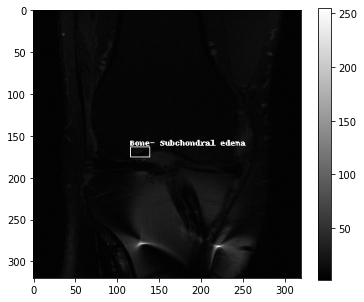

In [401]:
# Display an imageslice with annotations

slice_choice = 16
labels_for_slice = labels_for_file.loc[labels_for_file['slice'] == slice_choice].values.tolist()
arrimg = np.squeeze(img_data[slice_choice,:,:])
image_2d_scaled = (np.maximum(arrimg,0) / arrimg.max()) * 255.0
image_2d_scaled = Image.fromarray(np.uint8(image_2d_scaled))
annotated_img = plot_bounding_box(image_2d_scaled, labels_for_slice)
plt.figure(figsize = (6,5))
plt.imshow(annotated_img,'gray')
plt.colorbar()
plt.show()

In [402]:
val = data_folder / "singlecoil_val"
alls = data_folder / "singlecoil_all"

In [403]:
# for fname in val.iterdir():
#     shutil.copy(fname, alls / fname.name)
len(list(val.iterdir())), len(list(orig.iterdir())), len(list(val.iterdir())) + len(list(orig.iterdir())), len(list(alls.iterdir()))

(199, 973, 1172, 1172)

In [404]:
partition = orig

annots = 0
vols = 0
for fname in partition.iterdir():
    name = fname.name[:-3]
    hits = (df["file"] == name).sum()
    annots += hits
    vols += (hits > 0)
print(vols, annots)

# 155 volumes with 2501 annotations for val, 819 volumes with 13666 annotations for orig

819 13666


In [405]:
df["label"].value_counts()  # So use Meniscus Tear and Cartilage - Partial Thickness loss/defect?

Meniscus Tear                                5658
Cartilage - Partial Thickness loss/defect    2985
Joint Effusion                               1311
Bone-Fracture/Contusion/dislocation          1060
Bone- Subchondral edema                       986
Periarticular cysts                           864
Ligament - ACL Low Grade sprain               765
Ligament - ACL High Grade Sprain              678
Cartilage - Full Thickness loss/defect        615
Ligament - MCL Low-Mod Grade Sprain           285
Displaced Meniscal Tissue                     232
Bone - Lesion                                 183
Ligament - PCL Low-Mod grade sprain           142
LCL Complex - Low-Mod Grade Sprain            130
Soft Tissue Lesion                             90
Muscle Strain                                  65
Joint Bodies                                   38
Patellar Retinaculum - High grade sprain       24
Ligament - PCL High Grade                      18
LCL Complex- High Grade Sprain                 14


In [406]:
pathologies = ["Meniscus Tear", "Cartilage - Partial Thickness loss/defect", "Bone-Fracture/Contusion/dislocation", "Bone- Subchondral edema"]
pathology_index = 2

partition = test

annots = 0
vols = 0
for fname in partition.iterdir():
    name = fname.name[:-3]
    hits = df[(df["file"] == name) & (df["label"] == pathologies[pathology_index])]
    annots += len(hits)
    vols += (len(hits) > 0)
print(vols, annots)

# 155 volumes with 2501 annotations for val, 819 volumes with 13666 annotations for orig

# Meniscus Tear: 103 volumes with 814 annots for val, 560 volumes with 4844 annots for orig
# Cartilage - Partial Thickness loss/defect: 97 volumes with 491 annots for val, 491 volumes with 2494 annots for orig

# Bone-Fracture/Contusion/dislocation: 18, 185 VS. 101, 875 (orig) VS. 17 123 (test)
# Bone- Subchondral edema: 29 173 VS. 167 813 (orig) VS. 39 203 (test)

17 123


## DataLoaders

In [407]:
import logging
import os
import pickle
import random
import xml.etree.ElementTree as etree
from pathlib import Path
from typing import (
    Any,
    Callable,
    Dict,
    List,
    NamedTuple,
    Optional,
    Sequence,
    Tuple,
    Union,
)
from warnings import warn

import h5py
import numpy as np
import pandas as pd
import requests
import torch
import yaml


class FastMRIRawDataSample(NamedTuple):
    fname: Path
    slice_ind: int
    metadata: Dict[str, Any]
    slice_pathologies: Sequence[str]
        
        
class PathologiesSliceDataset(torch.utils.data.Dataset):
    """
    A PyTorch Dataset that provides access to MR image slices.
    """

    def __init__(
        self,
        root: Union[str, Path, os.PathLike],
        challenge: str,
        transform: Optional[Callable] = None,
        use_dataset_cache: bool = False,
        sample_rate: Optional[float] = None,
        volume_sample_rate: Optional[float] = None,
        dataset_cache_file: Union[str, Path, os.PathLike] = "dataset_cache.pkl",
        num_cols: Optional[Tuple[int]] = None,
        raw_sample_filter: Optional[Callable] = None,
        pathology_df: Optional = None,
    ):
        """
        Args:
            root: Path to the dataset.
            challenge: "singlecoil" or "multicoil" depending on which challenge
                to use.
            transform: Optional; A callable object that pre-processes the raw
                data into appropriate form. The transform function should take
                'kspace', 'target', 'attributes', 'filename', and 'slice' as
                inputs. 'target' may be null for test data.
            use_dataset_cache: Whether to cache dataset metadata. This is very
                useful for large datasets like the brain data.
            sample_rate: Optional; A float between 0 and 1. This controls what fraction
                of the slices should be loaded. Defaults to 1 if no value is given.
                When creating a sampled dataset either set sample_rate (sample by slices)
                or volume_sample_rate (sample by volumes) but not both.
            volume_sample_rate: Optional; A float between 0 and 1. This controls what fraction
                of the volumes should be loaded. Defaults to 1 if no value is given.
                When creating a sampled dataset either set sample_rate (sample by slices)
                or volume_sample_rate (sample by volumes) but not both.
            dataset_cache_file: Optional; A file in which to cache dataset
                information for faster load times.
            num_cols: Optional; If provided, only slices with the desired
                number of columns will be considered.
            raw_sample_filter: Optional; A callable object that takes an raw_sample
                metadata as input and returns a boolean indicating whether the
                raw_sample should be included in the dataset.
            pathology_df: fastMRI+ pathology dataframe.
        """
        if challenge not in ("singlecoil", "multicoil"):
            raise ValueError('challenge should be either "singlecoil" or "multicoil"')

        if sample_rate is not None and volume_sample_rate is not None:
            raise ValueError(
                "either set sample_rate (sample by slices) or volume_sample_rate (sample by volumes) but not both"
            )

        self.dataset_cache_file = Path(dataset_cache_file)

        self.transform = transform
        
        # Pathologies were labeled using RSS, so always use RSS.
#         self.recons_key = (
#             "reconstruction_esc" if challenge == "singlecoil" else "reconstruction_rss"
#         )
        self.recons_key = "reconstruction_rss"
        
        self.raw_samples = []
        if raw_sample_filter is None:
            self.raw_sample_filter = lambda raw_sample: True
        else:
            self.raw_sample_filter = raw_sample_filter
            
        self.pathology_df = pathology_df

        # set default sampling mode if none given
        if sample_rate is None:
            sample_rate = 1.0
        if volume_sample_rate is None:
            volume_sample_rate = 1.0

        # load dataset cache if we have and user wants to use it
        if self.dataset_cache_file.exists() and use_dataset_cache:
            with open(self.dataset_cache_file, "rb") as f:
                dataset_cache = pickle.load(f)
        else:
            dataset_cache = {}

        # check if our dataset is in the cache
        # if there, use that metadata, if not, then regenerate the metadata
        if dataset_cache.get(root) is None or not use_dataset_cache:
            files = list(Path(root).iterdir())
            for fname in sorted(files):
                metadata, num_slices = self._retrieve_metadata(fname)

                new_raw_samples = []
                for slice_ind in range(num_slices):
                    raw_sample = FastMRIRawDataSample(fname, slice_ind, metadata, [])
                    # Apply pathology filter here
                    filtered_sample, keep = self.raw_sample_filter(raw_sample)
                    if keep:
                        new_raw_samples.append(filtered_sample)
                self.raw_samples += new_raw_samples

            if dataset_cache.get(root) is None and use_dataset_cache:
                dataset_cache[root] = self.raw_samples
                logging.info(f"Saving dataset cache to {self.dataset_cache_file}.")
                with open(self.dataset_cache_file, "wb") as cache_f:
                    pickle.dump(dataset_cache, cache_f)
        else:
            logging.info(f"Using dataset cache from {self.dataset_cache_file}.")
            self.raw_samples = dataset_cache[root]

        # subsample if desired
        if sample_rate < 1.0:  # sample by slice
            random.shuffle(self.raw_samples)
            num_raw_samples = round(len(self.raw_samples) * sample_rate)
            self.raw_samples = self.raw_samples[:num_raw_samples]
        elif volume_sample_rate < 1.0:  # sample by volume
            vol_names = sorted(list(set([f[0].stem for f in self.raw_samples])))
            random.shuffle(vol_names)
            num_volumes = round(len(vol_names) * volume_sample_rate)
            sampled_vols = vol_names[:num_volumes]
            self.raw_samples = [
                raw_sample
                for raw_sample in self.raw_samples
                if raw_sample[0].stem in sampled_vols
            ]

        if num_cols:
            self.raw_samples = [
                ex
                for ex in self.raw_samples
                if ex[2]["encoding_size"][1] in num_cols  # type: ignore
            ]
            
        # Equalise number of pathology examples
#         print(self.raw_samples[0].slice_pathologies)

    def _retrieve_metadata(self, fname):
        with h5py.File(fname, "r") as hf:
            et_root = etree.fromstring(hf["ismrmrd_header"][()])

            enc = ["encoding", "encodedSpace", "matrixSize"]
            enc_size = (
                int(et_query(et_root, enc + ["x"])),
                int(et_query(et_root, enc + ["y"])),
                int(et_query(et_root, enc + ["z"])),
            )
            rec = ["encoding", "reconSpace", "matrixSize"]
            recon_size = (
                int(et_query(et_root, rec + ["x"])),
                int(et_query(et_root, rec + ["y"])),
                int(et_query(et_root, rec + ["z"])),
            )

            lims = ["encoding", "encodingLimits", "kspace_encoding_step_1"]
            enc_limits_center = int(et_query(et_root, lims + ["center"]))
            enc_limits_max = int(et_query(et_root, lims + ["maximum"])) + 1

            padding_left = enc_size[1] // 2 - enc_limits_center
            padding_right = padding_left + enc_limits_max

            num_slices = hf["kspace"].shape[0]
            
            pathologies = self.pathology_df[self.pathology_df["file"] == fname.name[:-3]]
            
            metadata = {
                "padding_left": padding_left,
                "padding_right": padding_right,
                "encoding_size": enc_size,
                "recon_size": recon_size,
                "pathologies": pathologies,
                **hf.attrs,
            }
            
        return metadata, num_slices

    def __len__(self):
        return len(self.raw_samples)

    def __getitem__(self, i: int):
        fname, dataslice, metadata = self.raw_samples[i]

        with h5py.File(fname, "r") as hf:
            kspace = hf["kspace"][dataslice]

            mask = np.asarray(hf["mask"]) if "mask" in hf else None

            target = hf[self.recons_key][dataslice] if self.recons_key in hf else None

            attrs = dict(hf.attrs)
            attrs.update(metadata)

        if self.transform is None:
            sample = (kspace, mask, target, attrs, fname.name, dataslice)
        else:
            sample = self.transform(kspace, mask, target, attrs, fname.name, dataslice)

        return sample

In [408]:
import copy

pathologies = ["Bone-Fracture/Contusion/dislocation", "Bone- Subchondral edema"]

def filter_pathologies(pathologies, raw_sample):
    fname = raw_sample.fname
    slice_ind = raw_sample.slice_ind
    metadata = raw_sample.metadata
    
    pathology_df_for_volume = metadata["pathologies"]
    # Match on pathology and slice
    match = pathology_df_for_volume[
        (pathology_df_for_volume["label"].isin(pathologies)) & (pathology_df_for_volume["slice"] == slice_ind)
    ]
    
    # Pathologies in this slice
    raw_sample = raw_sample._replace(slice_pathologies=match["label"].values)
    keep = match.values.size > 0  # empty list if no match, or row from dataframe if match (size=8)
#     print(match["label"].values, keep)
    return raw_sample, keep
    
pathology_filter = partial(filter_pathologies, pathologies)

In [409]:
filtered_slices = PathologiesSliceDataset(
    root = test,
    challenge = "singlecoil",  # Doesn't do anything right now, because pathologies labeled using RSS.
    transform = None,
    raw_sample_filter = pathology_filter,
    pathology_df = df,
    sample_rate = 1,
)

len(filtered_slices.raw_samples)

297

### Filter to equalise pathologies

In [410]:
from collections import defaultdict

total_pathologies = defaultdict(int)

for sample in filtered_slices.raw_samples:
#     print(sample.fname.name, sample.slice_ind, sample.slice_pathologies)
    if len(sample.slice_pathologies) > 1:
        continue  # Skip double pathologies for simplicity
    total_pathologies[sample.slice_pathologies[0]] += 1
    
print(total_pathologies)

defaultdict(<class 'int'>, {'Bone- Subchondral edema': 181, 'Bone-Fracture/Contusion/dislocation': 88})


In [411]:
# Min value in dict
min_key = min(total_pathologies.keys(), key=(lambda k: total_pathologies[k]))
min_value = total_pathologies[min_key]
print(min_key, min_value)

Bone-Fracture/Contusion/dislocation 88


In [412]:
import random

seed = 0 
random.seed(seed)
random.shuffle(filtered_slices.raw_samples)

kept_pathologies = defaultdict(int)
kept_samples = []

for sample in filtered_slices.raw_samples:
    if len(sample.slice_pathologies) > 1:
        continue  # Skip double pathologies for simplicity
    current_pathology = sample.slice_pathologies[0]
    
    if kept_pathologies[current_pathology] < min_value:
        kept_pathologies[current_pathology] += 1
        kept_samples.append(sample)
    else:
        continue
        
print(kept_pathologies)

defaultdict(<class 'int'>, {'Bone- Subchondral edema': 88, 'Bone-Fracture/Contusion/dislocation': 88})


In [328]:
check_nums = defaultdict(int)

for sample in kept_samples:
    assert len(sample.slice_pathologies) == 1
    check_nums[sample.slice_pathologies[0]] += 1
    
print(check_nums)

defaultdict(<class 'int'>, {'Bone-Fracture/Contusion/dislocation': 88, 'Bone- Subchondral edema': 88})


In [413]:
# TODO: 
# Implement above post-filter in PathologySliceDataset, then just use split from NeurIPS paper for data.
# Make split in two? three? sets for multiple experiment setup.
# Train classifier on that data x2/x3 (train, use val for early stopping).
# Do Type1 error test on this.

# vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
# Actually, can do healthy from sick using https://github.com/microsoft/fastmri-plus knee_file_list.csv!
# vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv

checked_path = '/home/timsey/Projects/fastmri-plus/Annotations/knee_file_list.csv'

# Skip final row because it's "Knee data" for some reason
check_df = pd.read_csv(checked_path, names=["file"], index_col=None, header=None, skipfooter=1)

/home/timsey/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


In [422]:
not_checked = 0
no_pathologies = 0
any_pathologies = 0

partition = alls

for fname in partition.iterdir():
    name = fname.name[:-3]
    if name not in check_df["file"].values:
#         print(name, "not checked.")
        not_checked += 1
        continue
    
    num_pathologies = len(df[df["file"] == name])
    if num_pathologies == 0:
        no_pathologies += 1
#         print(name, "0 pathologies.")
    else:
        any_pathologies += 1
#         print(name, num_pathologies, "pathologies")

# Volumes, not yet slices: though probably bad to use "clean" slices from non-clean volumes.
# So use clean volumes, non-clean volumes, and make sure to grab corresponding slices somehow?
# How do they do it in the paper Teddy linked?
print(not_checked, no_pathologies, any_pathologies)

# Train: 0 122 657 = 5.385
#   Val: 0  44 155 = 3.523
#  Test: 0  32 162 = 5.063

#  Orig: 0 154 819 = 
#  Alls: 0 198 974 = 

0 198 974


In [417]:
len(list(alls.iterdir()))

1172

In [ ]:
import logging
import os
import pickle
import random
import xml.etree.ElementTree as etree
from pathlib import Path
from typing import (
    Any,
    Callable,
    Dict,
    List,
    NamedTuple,
    Optional,
    Sequence,
    Tuple,
    Union,
)
from warnings import warn

import h5py
import numpy as np
import pandas as pd
import requests
import torch
import yaml


class FastMRIRawDataSample(NamedTuple):
    fname: Path
    slice_ind: int
    metadata: Dict[str, Any]
    slice_pathologies: Sequence[str]
        
        
class PathologiesSliceDataset(torch.utils.data.Dataset):
    """
    A PyTorch Dataset that provides access to MR image slices.
    """

    def __init__(
        self,
        root: Union[str, Path, os.PathLike],
        challenge: str,
        transform: Optional[Callable] = None,
        use_dataset_cache: bool = False,
        sample_rate: Optional[float] = None,
        volume_sample_rate: Optional[float] = None,
        dataset_cache_file: Union[str, Path, os.PathLike] = "dataset_cache.pkl",
        num_cols: Optional[Tuple[int]] = None,
        raw_sample_filter: Optional[Callable] = None,
        pathology_df: Optional = None,
    ):
        """
        Args:
            root: Path to the dataset.
            challenge: "singlecoil" or "multicoil" depending on which challenge
                to use.
            transform: Optional; A callable object that pre-processes the raw
                data into appropriate form. The transform function should take
                'kspace', 'target', 'attributes', 'filename', and 'slice' as
                inputs. 'target' may be null for test data.
            use_dataset_cache: Whether to cache dataset metadata. This is very
                useful for large datasets like the brain data.
            sample_rate: Optional; A float between 0 and 1. This controls what fraction
                of the slices should be loaded. Defaults to 1 if no value is given.
                When creating a sampled dataset either set sample_rate (sample by slices)
                or volume_sample_rate (sample by volumes) but not both.
            volume_sample_rate: Optional; A float between 0 and 1. This controls what fraction
                of the volumes should be loaded. Defaults to 1 if no value is given.
                When creating a sampled dataset either set sample_rate (sample by slices)
                or volume_sample_rate (sample by volumes) but not both.
            dataset_cache_file: Optional; A file in which to cache dataset
                information for faster load times.
            num_cols: Optional; If provided, only slices with the desired
                number of columns will be considered.
            raw_sample_filter: Optional; A callable object that takes an raw_sample
                metadata as input and returns a boolean indicating whether the
                raw_sample should be included in the dataset.
            pathology_df: fastMRI+ pathology dataframe.
        """
        if challenge not in ("singlecoil", "multicoil"):
            raise ValueError('challenge should be either "singlecoil" or "multicoil"')

        if sample_rate is not None and volume_sample_rate is not None:
            raise ValueError(
                "either set sample_rate (sample by slices) or volume_sample_rate (sample by volumes) but not both"
            )

        self.dataset_cache_file = Path(dataset_cache_file)

        self.transform = transform
        
        # Pathologies were labeled using RSS, so always use RSS.
#         self.recons_key = (
#             "reconstruction_esc" if challenge == "singlecoil" else "reconstruction_rss"
#         )
        self.recons_key = "reconstruction_rss"
        
        self.raw_samples = []
        if raw_sample_filter is None:
            self.raw_sample_filter = lambda raw_sample: True
        else:
            self.raw_sample_filter = raw_sample_filter
            
        self.pathology_df = pathology_df

        # set default sampling mode if none given
        if sample_rate is None:
            sample_rate = 1.0
        if volume_sample_rate is None:
            volume_sample_rate = 1.0

        # load dataset cache if we have and user wants to use it
        if self.dataset_cache_file.exists() and use_dataset_cache:
            with open(self.dataset_cache_file, "rb") as f:
                dataset_cache = pickle.load(f)
        else:
            dataset_cache = {}

        # check if our dataset is in the cache
        # if there, use that metadata, if not, then regenerate the metadata
        if dataset_cache.get(root) is None or not use_dataset_cache:
            files = list(Path(root).iterdir())
            for fname in sorted(files):
                metadata, num_slices = self._retrieve_metadata(fname)

                new_raw_samples = []
                for slice_ind in range(num_slices):
                    raw_sample = FastMRIRawDataSample(fname, slice_ind, metadata, [])
                    # Apply pathology filter here
                    filtered_sample, keep = self.raw_sample_filter(raw_sample)
                    if keep:
                        new_raw_samples.append(filtered_sample)
                self.raw_samples += new_raw_samples

            if dataset_cache.get(root) is None and use_dataset_cache:
                dataset_cache[root] = self.raw_samples
                logging.info(f"Saving dataset cache to {self.dataset_cache_file}.")
                with open(self.dataset_cache_file, "wb") as cache_f:
                    pickle.dump(dataset_cache, cache_f)
        else:
            logging.info(f"Using dataset cache from {self.dataset_cache_file}.")
            self.raw_samples = dataset_cache[root]

        # subsample if desired
        if sample_rate < 1.0:  # sample by slice
            random.shuffle(self.raw_samples)
            num_raw_samples = round(len(self.raw_samples) * sample_rate)
            self.raw_samples = self.raw_samples[:num_raw_samples]
        elif volume_sample_rate < 1.0:  # sample by volume
            vol_names = sorted(list(set([f[0].stem for f in self.raw_samples])))
            random.shuffle(vol_names)
            num_volumes = round(len(vol_names) * volume_sample_rate)
            sampled_vols = vol_names[:num_volumes]
            self.raw_samples = [
                raw_sample
                for raw_sample in self.raw_samples
                if raw_sample[0].stem in sampled_vols
            ]

        if num_cols:
            self.raw_samples = [
                ex
                for ex in self.raw_samples
                if ex[2]["encoding_size"][1] in num_cols  # type: ignore
            ]
            
        # Equalise number of pathology examples
#         print(self.raw_samples[0].slice_pathologies)

    def _retrieve_metadata(self, fname):
        with h5py.File(fname, "r") as hf:
            et_root = etree.fromstring(hf["ismrmrd_header"][()])

            enc = ["encoding", "encodedSpace", "matrixSize"]
            enc_size = (
                int(et_query(et_root, enc + ["x"])),
                int(et_query(et_root, enc + ["y"])),
                int(et_query(et_root, enc + ["z"])),
            )
            rec = ["encoding", "reconSpace", "matrixSize"]
            recon_size = (
                int(et_query(et_root, rec + ["x"])),
                int(et_query(et_root, rec + ["y"])),
                int(et_query(et_root, rec + ["z"])),
            )

            lims = ["encoding", "encodingLimits", "kspace_encoding_step_1"]
            enc_limits_center = int(et_query(et_root, lims + ["center"]))
            enc_limits_max = int(et_query(et_root, lims + ["maximum"])) + 1

            padding_left = enc_size[1] // 2 - enc_limits_center
            padding_right = padding_left + enc_limits_max

            num_slices = hf["kspace"].shape[0]
            
            pathologies = self.pathology_df[self.pathology_df["file"] == fname.name[:-3]]
            
            metadata = {
                "padding_left": padding_left,
                "padding_right": padding_right,
                "encoding_size": enc_size,
                "recon_size": recon_size,
                "pathologies": pathologies,
                **hf.attrs,
            }
            
        return metadata, num_slices

    def __len__(self):
        return len(self.raw_samples)

    def __getitem__(self, i: int):
        fname, dataslice, metadata = self.raw_samples[i]

        with h5py.File(fname, "r") as hf:
            kspace = hf["kspace"][dataslice]

            mask = np.asarray(hf["mask"]) if "mask" in hf else None

            target = hf[self.recons_key][dataslice] if self.recons_key in hf else None

            attrs = dict(hf.attrs)
            attrs.update(metadata)

        if self.transform is None:
            sample = (kspace, mask, target, attrs, fname.name, dataslice)
        else:
            sample = self.transform(kspace, mask, target, attrs, fname.name, dataslice)

        return sample